# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

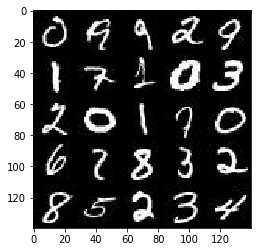

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

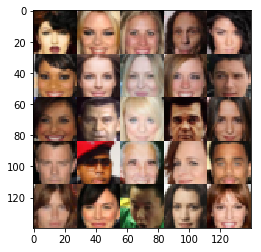

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x 1/3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 28x28x128 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, depth = data_shape
    input_real, input_z, learning_rate_ = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, depth, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4120... Generator Loss: 10.3938
Epoch 1/2... Discriminator Loss: 0.8118... Generator Loss: 7.5111
Epoch 1/2... Discriminator Loss: 0.3331... Generator Loss: 8.1812
Epoch 1/2... Discriminator Loss: 0.3315... Generator Loss: 8.0345
Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 8.1024
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 8.8436
Epoch 1/2... Discriminator Loss: 0.3927... Generator Loss: 7.9386
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 8.8226
Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 9.1301
Epoch 1/2... Discriminator Loss: 0.3504... Generator Loss: 8.9741


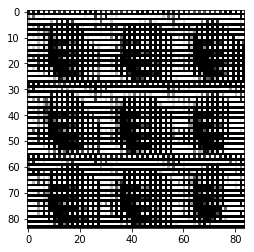

Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 8.8832
Epoch 1/2... Discriminator Loss: 0.3285... Generator Loss: 9.0360
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 9.3484
Epoch 1/2... Discriminator Loss: 0.4009... Generator Loss: 8.5884
Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 9.8713
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 9.8977
Epoch 1/2... Discriminator Loss: 0.3548... Generator Loss: 8.5519
Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 8.5159
Epoch 1/2... Discriminator Loss: 0.3978... Generator Loss: 8.4146
Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 9.0456


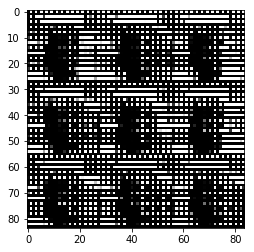

Epoch 1/2... Discriminator Loss: 0.3260... Generator Loss: 9.0079
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 8.5791
Epoch 1/2... Discriminator Loss: 0.3334... Generator Loss: 9.2419
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 8.9888
Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 9.3413
Epoch 1/2... Discriminator Loss: 1.9943... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 6.4290... Generator Loss: 32.0691
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 6.1975
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 4.8407
Epoch 1/2... Discriminator Loss: 28.6994... Generator Loss: 16.7946


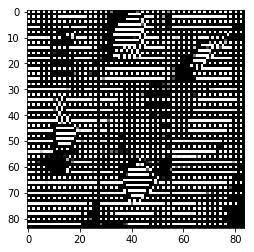

Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 3.6330
Epoch 2/2... Discriminator Loss: 0.4673... Generator Loss: 7.2601
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 1.5920
Epoch 2/2... Discriminator Loss: 3.2776... Generator Loss: 0.1333
Epoch 2/2... Discriminator Loss: 2.5651... Generator Loss: 0.2123
Epoch 2/2... Discriminator Loss: 1.7841... Generator Loss: 0.4484
Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.2105


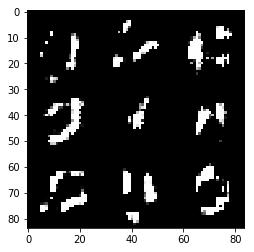

Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 1.0732
Epoch 2/2... Discriminator Loss: 2.2172... Generator Loss: 0.2410
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 2.2171
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 3.3197
Epoch 2/2... Discriminator Loss: 0.6307... Generator Loss: 1.6456
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.4417
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.4292
Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 1.9891
Epoch 2/2... Discriminator Loss: 0.4151... Generator Loss: 2.9576
Epoch 2/2... Discriminator Loss: 2.8827... Generator Loss: 0.1111


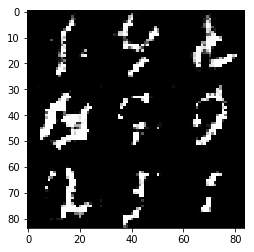

Epoch 2/2... Discriminator Loss: 0.5981... Generator Loss: 1.9956
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 1.9725
Epoch 2/2... Discriminator Loss: 2.0804... Generator Loss: 3.9302
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 2.7031
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 2.2340
Epoch 2/2... Discriminator Loss: 1.5425... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.1737
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.3356
Epoch 2/2... Discriminator Loss: 1.5744... Generator Loss: 1.3957


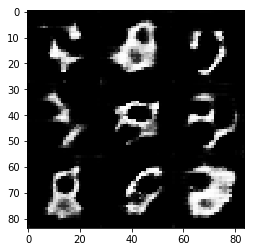

ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [14]:
batch_size = 200
z_dim = 500
learning_rate = 0.0046
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 5.8476
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 7.6555
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 2.8536... Generator Loss: 7.2971
Epoch 1/1... Discriminator Loss: 4.3704... Generator Loss: 6.1771
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 2.0170... Generator Loss: 0.2791
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.4098


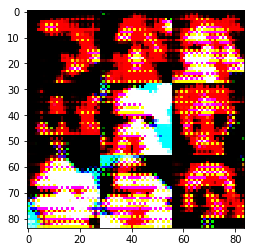

Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.3232
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 5.0847
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 2.1114... Generator Loss: 6.2059
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.9538
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.9906
Epoch 1/1... Discriminator Loss: 3.7875... Generator Loss: 6.8277
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.2501
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 4.1888


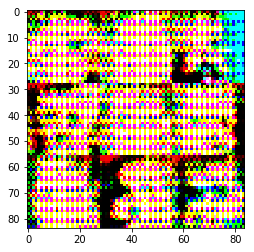

Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 4.2836
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 6.8244
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.1448
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.2146
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 3.8880
Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 4.0355
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 4.1518
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 4.7638


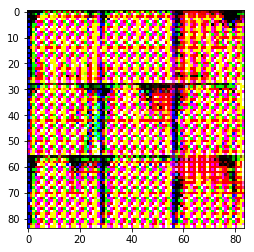

Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 4.8496
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 6.0176
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 6.2804
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 4.6565
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 4.3852
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 4.4513
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 4.7940
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 6.0276
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 5.4841
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 6.0313


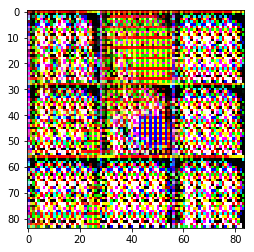

Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 5.3018
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 4.8029
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 4.8471
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 6.2783
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 5.0080
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 6.0007
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 10.3097
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 9.0251
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 7.8035
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 9.8738


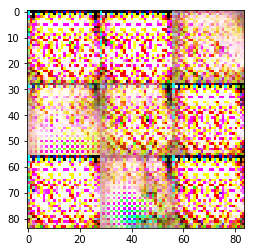

Epoch 1/1... Discriminator Loss: 2.7933... Generator Loss: 3.2398
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 2.7909
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 2.6619
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 1.6898


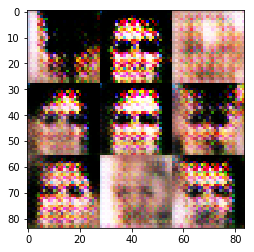

Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 2.6475... Generator Loss: 3.5377
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.5845


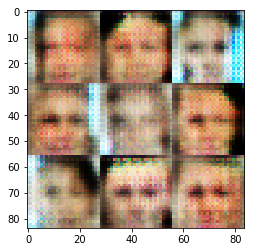

Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 3.4682... Generator Loss: 3.2790
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6379


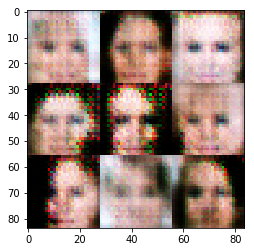

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6441


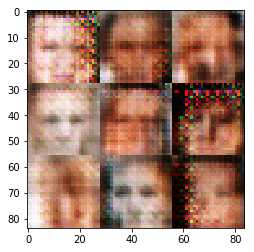

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.9757


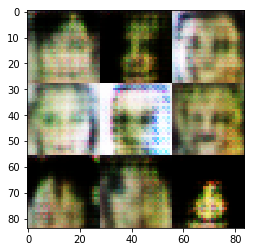

Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.8492


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [15]:
batch_size = 200
z_dim = 500
learning_rate = 0.0046
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.